# Assignment: Trees

## Do two questions in total: "Q1+Q2" or "Q1+Q3"

`! git clone https://github.com/ds3001f25/linear_models_assignment.git`

In [34]:
!git clone https://github.com/cayang17/trees_assignment
%cd trees_assignment

Cloning into 'trees_assignment'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 6 (from 1)
Receiving objects: 100% (9/9), 372.48 KiB | 7.16 MiB/s, done.
/content/linear_models_assignment/linear_models_assignment/linear_models_assignment/linear_models_assignment/linear_models_assignment/trees_assignment/trees_assignment/trees_assignment


**Q1.** Please answer the following questions in your own words.
1. Why is the Gini a good loss function for categorical target variables?
2. Why do trees tend to overfit, and how can this tendency be constrained?
3. True or false, and explain: Trees only really perform well in situations with lots of categorical variables as features/covariates.
4. Why don't most versions of classification/regression tree concept allow for more than two branches after a split?
5. What are some heuristic ways you can examine a tree and decide whether it is probably over- or under-fitting?

1) Gini impurity measures how mixed the classes are in a node. It is zero when a node is pure and larger when classes are evenly split. Since it relies only on class proportions, it works naturally for categorical outcomes and makes computation more efficient,

2) Trees overfit because they keep splitting to perfectly match the training data, including noise. This can be controlled by limiting depth, using validation data to make sure there are minimum sample sizes in nodes, pruning, and tuning hyperparameters.

3) False. Trees handle categorical variables well, but they are also very effective with numeric variables by splitting on thresholds. Many tree models rely mostly on numeric features.

4) Most decision trees are binary because binary splits keep the search space manageable and make optimization tractable. Any multi-way split can be represented as a sequence of binary splits without losing modeling power.

5) Utilizing train vs. test metrics and looking at tree depth can help you identify. You can tell if a tree is overfitting because it shows up as a deep tree with tina leaves, very low training error, and worse test performance. Underfitting appears as a shallow tree with poor performance even on training data.

**Q2.** This is a case study about classification and regression trees.

1. Load the `Breast Cancer METABRIC.csv` dataset. How many observations and variables does it contain? Print out the first few rows of data.

2.  We'll use a consistent set of feature/explanatory variables. For numeric variables, we'll include `Tumor Size`, `Lymph nodes examined positive`, `Age at Diagnosis`. For categorical variables, we'll include `Tumor Stage`, `Chemotherapy`, and `Cancer Type Detailed`. One-hot-encode the categorical variables and concatenate them with the numeric variables into a feature/covariate matrix, $X$.

3. Let's predict `Overall Survival Status` given the features/covariates $X$. There are 528 missing values, unfortunately: Either drop those rows from your data or add them as a category to predict. Constrain the minimum samples per leaf to 10. Print a dendrogram of the tree. Print a confusion matrix of the algorithm's performance. What is the accuracy?

4. For your model in part three, compute three statistics:
    - The **true positive rate** or **sensitivity**:
        $$
        TPR = \dfrac{TP}{TP+FN}
        $$
    - The **true negative rate** or **specificity**:
        $$
        TNR = \dfrac{TN}{TN+FP}
        $$
    Does your model tend to perform better with respect to one of these metrics?

5. Let's predict `Overall Survival (Months)` given the features/covariates $X$. Use the train/test split to pick the optimal `min_samples_leaf` value that gives the highest $R^2$ on the test set (it's about 110). What is the $R^2$? Plot the test values against the predicted values. How do you feel about this model for clinical purposes?

In [46]:
#2.1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    mean_squared_error,
    r2_score
)

# Load data (adjust path if needed)
df = pd.read_csv("./data/Breast Cancer METABRIC.csv")

print(f"Number of observations: {df.shape[0]}, Number of variables: {df.shape[1]}")
df.head()

Number of observations: 2509, Number of variables: 34


,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,...,Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Sex,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
0,MB-0000,75.65,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,No,claudin-low,1.0,Positve,...,Living,Negative,Yes,138.65,Not Recurred,Female,ER-/HER2-,22.0,2.0,Living
1,MB-0002,43.19,Breast Conserving,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,1.0,Positve,...,Living,Positive,Yes,83.52,Not Recurred,Female,ER+/HER2- High Prolif,10.0,1.0,Living
2,MB-0005,48.87,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,No,151.28,Recurred,Female,NaN,15.0,2.0,Died of Disease
3,MB-0006,47.68,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,Yes,LumB,1.0,Positve,...,Living,Positive,Yes,162.76,Not Recurred,Female,NaN,25.0,2.0,Living
4,MB-0008,76.97,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,Yes,18.55,Recurred,Female,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


In [36]:
#2.2)
numeric_vars = [
    "Tumor Size",
    "Lymph nodes examined positive",
    "Age at Diagnosis",
]

categorical_vars = [
    "Tumor Stage",
    "Chemotherapy",
    "Cancer Type Detailed",
]

# Split into numeric and categorical parts
X_numeric = df[numeric_vars]

# One-hot encode the categorical features
X_categorical = pd.get_dummies(df[categorical_vars], drop_first=True)

# Combine into a single design matrix
X = pd.concat([X_numeric, X_categorical], axis=1)

X.head()

,Tumor Size,Lymph nodes examined positive,Age at Diagnosis,Tumor Stage,Chemotherapy_Yes,Cancer Type Detailed_Breast Angiosarcoma,Cancer Type Detailed_Breast Invasive Ductal Carcinoma,Cancer Type Detailed_Breast Invasive Lobular Carcinoma,Cancer Type Detailed_Breast Invasive Mixed Mucinous Carcinoma,Cancer Type Detailed_Breast Mixed Ductal and Lobular Carcinoma,Cancer Type Detailed_Invasive Breast Carcinoma,Cancer Type Detailed_Metaplastic Breast Cancer
0,22.0,10.0,75.65,2.0,False,False,True,False,False,False,False,False
1,10.0,0.0,43.19,1.0,False,False,True,False,False,False,False,False
2,15.0,1.0,48.87,2.0,True,False,True,False,False,False,False,False
3,25.0,3.0,47.68,2.0,True,False,False,False,False,True,False,False
4,40.0,8.0,76.97,2.0,True,False,False,False,False,True,False,False


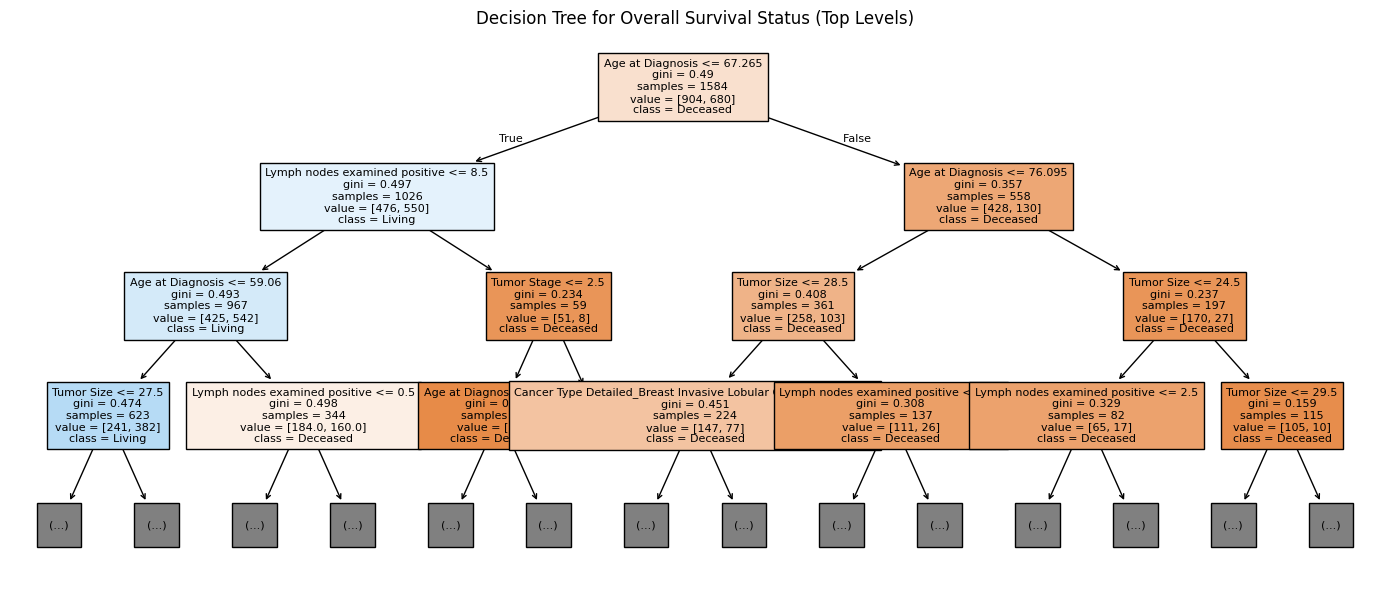

Accuracy: 0.6624685138539043


Predicted,Deceased,Living
Actual,,
Deceased,168,72
Living,62,95


In [48]:
#2.3)
# Target: Overall Survival Status (e.g., Deceased vs Living)
y_status = df["Overall Survival Status"]

# Combine X and y, clean rows
data_class = pd.concat([X, y_status], axis=1).dropna(subset=["Overall Survival Status"])

X_clean = data_class.drop(columns=["Overall Survival Status"])
y_clean = data_class["Overall Survival Status"]

# 80/20 train test split
X_train, X_test, y_train, y_test = train_test_split(
    X_clean,
    y_clean,
    test_size=0.2,
    random_state=100
)

tree_clf = DecisionTreeClassifier(
    min_samples_leaf=10,
    random_state=42
)
tree_clf.fit(X_train, y_train)

# Plot the top of the tree (dendrogram-style visualization)
plt.figure(figsize=(14, 6))
plot_tree(
    tree_clf,
    max_depth=3,                 # limit depth so it’s readable
    feature_names=X_train.columns,
    class_names=[str(c) for c in tree_clf.classes_],
    filled=True,
    fontsize=8
)
plt.title("Decision Tree for Overall Survival Status (Top Levels)")
plt.tight_layout()
plt.show()

# Predictions and accuracy
y_pred = tree_clf.predict(X_test)

tab = pd.crosstab(y_test, y_pred, rownames=["Actual"], colnames=["Predicted"])
acc = np.trace(tab) / len(y_test)

print("Accuracy:", acc)
tab



In [40]:
#2.4)
cm = tab.values

TN = cm[1, 1]  # Living predicted Living
FP = cm[1, 0]  # Living predicted Deceased
FN = cm[0, 1]  # Deceased predicted Living
TP = cm[0, 0]  # Deceased predicted Deceased

TPR = TP / (TP + FN)
TNR = TN / (TN + FP)

print("True Positive Rate (TPR):", TPR)
print("True Negative Rate (TNR):", TNR)


True Positive Rate (TPR): 0.7
True Negative Rate (TNR): 0.6050955414012739


Since TPR is higher than TNR, the model is better at identifying breast cancer deaths.

Best R^2 on test set: 0.15606360133972408
Best min_samples_leaf: 109


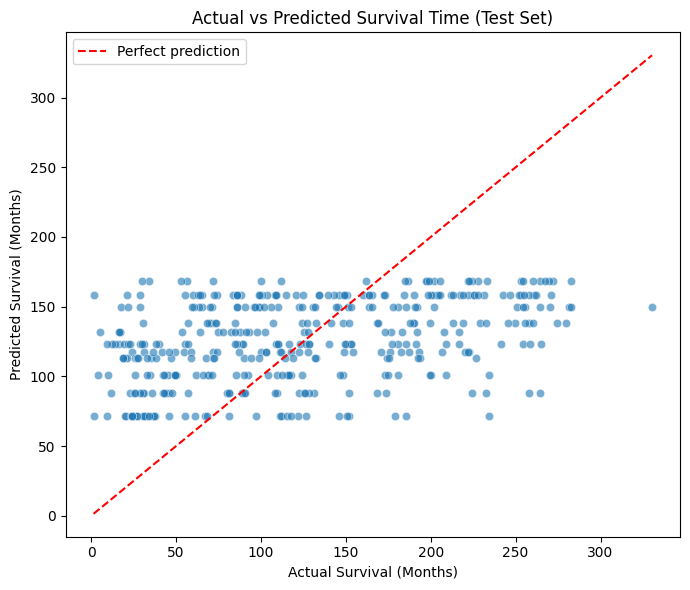

In [47]:
#2.5)
y_months = df["Overall Survival (Months)"]

# Combine and drop rows with missing survival months
data_reg = pd.concat([X, y_months], axis=1).dropna(subset=["Overall Survival (Months)"])

X_reg = data_reg.drop(columns=["Overall Survival (Months)"])
y_reg = data_reg["Overall Survival (Months)"]

# Train-test split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg,
    y_reg,
    test_size=0.2,
    random_state=100
)

best_r2 = float("-inf")
best_leaf = None

# Search over min_samples_leaf values
for leaf_size in range(10, 211):
    reg_tree = DecisionTreeRegressor(min_samples_leaf=leaf_size, random_state=42)
    reg_tree.fit(X_train_r, y_train_r)
    y_pred_r = reg_tree.predict(X_test_r)
    score = r2_score(y_test_r, y_pred_r)

    if score > best_r2:
        best_r2 = score
        best_leaf = leaf_size

print("Best R^2 on test set:", best_r2)
print("Best min_samples_leaf:", best_leaf)

best_tree = DecisionTreeRegressor(
    min_samples_leaf=best_leaf,  # best_leaf = 109
    random_state=42
)
best_tree.fit(X_train_r, y_train_r)

# Predict on the test set
y_pred_test = best_tree.predict(X_test_r)

# Scatter plot: actual vs predicted
plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test_r, y=y_pred_test, alpha=0.6)

# Ideal 45-degree line
plt.plot(
    [y_test_r.min(), y_test_r.max()],
    [y_test_r.min(), y_test_r.max()],
    color='red',
    linestyle='--',
    label='Perfect prediction'
)

plt.xlabel("Actual Survival (Months)")
plt.ylabel("Predicted Survival (Months)")
plt.title("Actual vs Predicted Survival Time (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()

The scatterplot shows a wide spreak of points with a weak positive trend. The test-set R^2 is also relatively low at 0.16.

This means that the model may be useful for exploratory analysis or identifying broad patters, but it would not be appropriate for predicting a patient's expected survival time and show not be used as the sole determinator of medical decisions.

**Q3.** This is a case study about trees using bond rating data. This is a dataset about bond ratings for different companies, alongside a bunch of business statistics and other data. Companies often have multiple reviews at different dates. We want to predict the bond rating (AAA, AA, A, BBB, BB, B, ..., C, D). Do business fundamentals predict the company's rating?

1. Load the `./data/corporate_ratings.csv` dataset. How many observations and variables does it contain? Print out the first few rows of data.

2.  Plot a histogram of the `ratings` variable. It turns out that the gradations of AAA/AA/A and BBB/BB/B and so on make it hard to get good results with trees. Collapse all AAA/AA/A ratings into just A, and similarly for B and C.

3. Use all of the variables **except** Rating, Date, Name, Symbol, and Rating Agency Name. To include Sector, make a dummy/one-hot-encoded representation and include it in your features/covariates. Collect the relevant variables into a data matrix $X$.

4. Do a train/test split of the data and use a decision tree classifier to predict the bond rating. Including a min_samples_leaf constraint can raise the accuracy and speed up computation time. Print a confusion matrix and the accuracy of your model. How well do you predict the different bond ratings?

5. If you include the rating agency as a feature/covariate/predictor variable, do the results change? How do you interpret this?